In [9]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *
from scipy.stats import multivariate_normal
import signal

In [2]:
def preprocess_program(program):
    p = convert_and_normalize_gm_structure(program)
    p = convert_uniform_structure(p)
    return p


def convert_and_normalize_gm_structure(text):
    # Regular expression to find gm structure
    pattern = r'gm\(\s*(\[[^\]]+\](?:,\s*\[[^\]]+\])*)\s*\)'
    
    # Match all occurrences of the structure
    matches = re.findall(pattern, text)
    
    # Process each match
    converted_text = text
    for match in matches:
        # Find all sets of [pi, mu, s] inside the matched string
        elements = re.findall(r'\[\s*([0-9.-]+)\s*,\s*([0-9.-]+)\s*,\s*([0-9.-]+)\s*\]', match)
        
        # Separate pi, mu, and s into their own lists
        pi_list = [float(e[0]) for e in elements]
        mu_list = [e[1] for e in elements]
        s_list = [e[2] for e in elements]
        
        # Normalize pi_list
        pi_sum = sum(pi_list)
        normalized_pi_list = [pi / pi_sum for pi in pi_list] if pi_sum != 0 else pi_list
        
        # Format the new gm structure with normalized pi_list
        new_gm = f'gm([{", ".join(f"{pi:.6f}" for pi in normalized_pi_list)}], [{", ".join(mu_list)}], [{", ".join(s_list)}])'
        
        # Replace the old structure with the new one in the text
        converted_text = converted_text.replace(f'gm({match})', new_gm)
    
    return converted_text

import re

def convert_uniform_structure(text):
    # Regular expression to find the structure uniform([a, b], c)
    pattern = r'uniform\(\s*\[\s*([0-9.-]+)\s*,\s*([0-9.-]+)\s*\]\s*,\s*([0-9.-]+)\s*\)'
    
    # Find all matches of uniform([a, b], c)
    matches = re.findall(pattern, text)
    
    # Process each match
    converted_text = text
    for match in matches:
        a = float(match[0])  # Extract 'a'
        b = float(match[1])  # Extract 'b'
        c = match[2]         # Extract 'c'
        
        # New value for 'a + b'
        new_b = a + b
        
        # Format the new uniform structure
        new_uniform = f'uniform([{a:.6f}, {new_b:.6f}], {c})'
        
        # Replace the old structure with the new one in the text
        old_uniform = f'uniform([{match[0]}, {match[1]}], {match[2]})'
        converted_text = converted_text.replace(old_uniform, new_uniform)
    
    return converted_text

In [11]:
data_var_list = ['a', 'b']
#data = np.random.uniform(0, 1, 100)
data = [[np.random.normal(1, 2), np.random.normal(8, 2)] for _ in range(10000)]

In [5]:
text_baseline = 'a = gm([1, 1, 2]);b = gm([1, 8, 2]);'
#text= 'b = gm([3, 4.3, 6])  - 3  * a;\na = gm([2.2, 1, 2.6]);'
text = 'a = 8 * uniform([7.000000, 8.800000], 1);\nb = gm([0.264706, 0.735294, 1], [5, 1, 1.4], [1, 8.0, 9.0]) * uniform([2.000000, 9.200000], 6);'
text_baseline = preprocess_program(text_baseline)
text = preprocess_program(text)
print(text)
compiledText=compile2SOGA_text(text)
compiledText_baseline=compile2SOGA_text(text_baseline)

a = 8 * uniform([7.000000, 15.800000], 1);
b = gm([0.042254, 0.798122, 0.159624], [0.735294, 1, 8.0], [1, 1.4, 9.0]) * uniform([2.000000, 11.200000], 6);


In [6]:
cfg = produce_cfg_text(compiledText)
cfg_baseline = produce_cfg_text(compiledText_baseline)


In [7]:
output_dist = start_SOGA(cfg)
output_dist_baseline = start_SOGA(cfg_baseline)

In [12]:



# Define a custom exception for timeouts
class TimeoutException(Exception):
    pass

# Define a handler function for the timeout
def handler(signum, frame):
    raise TimeoutException("Code execution exceeded time limit")


def compute_likelihood(output_dist):
    likelihood = np.zeros(len(data))
    #log_total_likelihood = 0
    sum_likelihood = 0
    for j in range(len(data)):
        indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
        for i in range(output_dist.gm.n_comp()):
            marginal_means = []
            covariance_index = []
            for element, index_list in indexes.items():
                marginal_means.append(output_dist.gm.mu[i][index_list][0])
                covariance_index.append(index_list[0])

            marginal_covariance_matrix = output_dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)]

            likelihood[j] = likelihood[j] + np.log(output_dist.gm.pi[i] * multivariate_normal.pdf(data[j], mean = marginal_means, cov = marginal_covariance_matrix, allow_singular=True))
        #log_total_likelihood = log_total_likelihood + np.log(likelihood[j])
        sum_likelihood = sum_likelihood + likelihood[j]
    #fitness = log_total_likelihood
    fitness = sum_likelihood/len(data)
    return fitness

# Main code
try:
    # Set the timeout handler to raise TimeoutException after 5 seconds
    signal.signal(signal.SIGALRM, handler)
    signal.alarm(5)  # Set the timeout to 5 seconds
    fitness = compute_likelihood(output_dist)
    fitness_baseline = compute_likelihood(output_dist_baseline)

    # Cancel the alarm if the code completes within the time limit
    signal.alarm(0)

except TimeoutException as e:
    print("Caught TimeoutException:", e)

print(fitness)
#print(fitness_baseline)

Caught TimeoutException: Code execution exceeded time limit
-382.6250315048766


In [9]:
output_dist.gm.mean()

array([91.21824   , 13.90358871])

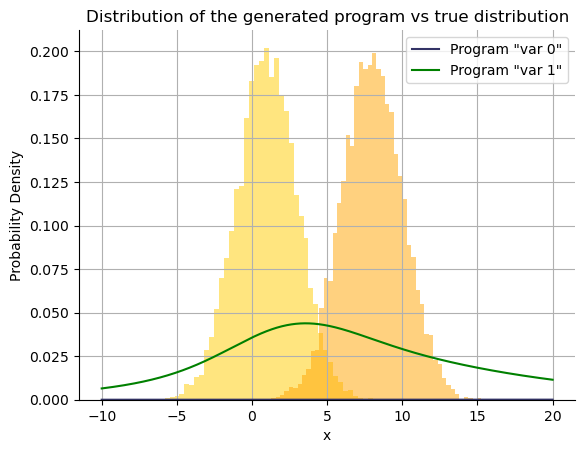

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import uniform

# Define the range for the uniform distribution
x = np.linspace(-10, 20, 1000)
y_0 = [output_dist.gm.marg_pdf(xi,0) for xi in x]
y_1 = [output_dist.gm.marg_pdf(xi,1) for xi in x]

fig, ax = plt.subplots()


ax.plot(x,y_0, label='Program "var 0"', color = '#333366')
ax.plot(x,y_1, label='Program "var 1"', color = 'green')

ax.hist([pair[0] for pair in data], bins=50, density=True, alpha=0.5, color = '#FFCC00')
ax.hist([pair[1] for pair in data], bins=50, density=True, alpha=0.5, color = 'orange')
ax.set_title("Distribution of the generated program vs true distribution")
ax.set_xlabel("x")
ax.set_ylabel("Probability Density")

# Remove the upper and right borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add grid, legend and show the plot
ax.grid(True)
ax.legend()
plt.show()

